In [28]:
train_data_path = './google_stock/Google_Stock_Price_train.csv'
test_data_path = './google_stock/Google_Stock_Price_test.csv'

In [2]:
import pandas as pd
import numpy as np
import math

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from tensorflow.keras import regularizers

In [29]:
df_train = pd.read_csv(train_data_path)
print(df_train.head())
print("*"*20)
df_test = pd.read_csv(test_data_path)
df_test.head()

       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800
********************


,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [30]:
df_train.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [31]:
print(f"Shape: \n{df_train.shape}")
print(f"Null Values: \n{df_train.isnull().values.sum()}")
print(f"Duplicated_values:\n {df_train.duplicated(subset=['Date']).value_counts()}")
print("*"*20)
print(f"Shape: \n{df_test.shape}")
print(f"Null Values: \n{df_test.isnull().values.sum()}")
print(f"Duplicated_values:\n{df_test.duplicated(subset=['Date']).value_counts()}")

Shape: 
(1258, 6)
Null Values: 
0
Duplicated_values:
 False    1258
Name: count, dtype: int64
********************
Shape: 
(20, 6)
Null Values: 
0
Duplicated_values:
False    20
Name: count, dtype: int64


In [32]:
df_train.info()
print("*"*20)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB
********************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB


In [33]:
def convert_to_float(series):
    try:
        float(series)
        return True
    except:
        return False

In [34]:
invalid_rows_close = df_train[~df_train['Close'].apply(convert_to_float)]
print(invalid_rows_close)

           Date    Open    High     Low     Close      Volume
451  10/18/2013  486.47  505.83  485.18  1,008.64  23,219,400
452  10/21/2013  503.84  507.60  497.91  1,000.55   7,283,700
453  10/22/2013  500.62  504.61  496.04  1,004.24   4,433,700
454  10/23/2013  498.63  515.44  498.45  1,028.59   5,346,300
455  10/24/2013  514.01  518.34  510.49  1,022.74   4,199,700
..          ...     ...     ...     ...       ...         ...
555   3/20/2014  597.73  602.55  595.45  1,193.88   3,381,900
556   3/21/2014  600.90  602.56  589.02  1,179.80   6,441,000
557   3/24/2014  589.88  590.24  570.84  1,154.76   6,096,800
558   3/25/2014  580.82  582.74  571.36  1,155.55   4,838,400
559   3/26/2014  578.84  583.60  563.64  1,128.87   5,179,200

[109 rows x 6 columns]


In [35]:
df_train['Close'] = pd.to_numeric(df_train['Close'].str.replace(",", ""), errors='coerce')
df_train['Volume'] = pd.to_numeric(df_train['Volume'].str.replace(",", ""), errors='coerce')

In [36]:
df_test['Volume'] = pd.to_numeric(df_test['Volume'].str.replace(",", ""), errors='coerce')

### Predict the next 5 days Close price using the LSTM 

In [37]:
df_train.shape

(1258, 6)

In [38]:
def scaler(df):
    '''Parameter: Dataframe 
    
    Output: dataframe after applying MinMaxScaler and removing 'Date' column '''
    df = df.iloc[: , 1:]
    scaler = MinMaxScaler()
    for column in df.columns:
        df[column] = scaler.fit_transform(df[[column]])
    
    return df


In [40]:
def sequential_data_selection(df):
    '''Returns X, y and accepts dataframe'''
    samples = 100
    step = 10
    X = []
    y = []

    # Loop through the training data and append 100 samples for X and the next 10 closing prices for y
    for i in range(0, df.shape[0] - samples - step + 1, step):
        # Take the next 100 records as input
        X.append(df.iloc[i:i+samples, 0:].values)
        
        # Take the next 10 closing prices (after the current 100-sample window)
        y.append(df.iloc[i+samples:i+samples+step, 4].values)

    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y


In [45]:
df_train = scaler(df_train)
x_train, y_train = sequential_data_selection(df_train)

IndexError: single positional indexer is out-of-bounds

In [42]:
print(x_train.shape)
y_train.shape

(115, 100, 5)


(115, 10)

In [49]:
# Initialize TimeSeriesSplit object with the desired number of splits
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Prepare to track results across folds
cv_losses = []

# Loop over each split for cross-validation
for fold, (train_index, val_index) in enumerate(tscv.split(x_train)):
    print(f"Training fold {fold + 1} out of {n_splits}")

    # Create train and validation sets
    X_train_fold, X_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Build the RNN model for this fold
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(units = 64, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(units = 32, recurrent_dropout=0.2))
    model.add(Dense(10))
    model.compile(optimizer = keras.optimizers.Adam(), loss = 'mean_squared_error')

    
    # Train the model on the current fold
    history = model.fit(X_train_fold, y_train_fold,
                        validation_data=(X_val_fold, y_val_fold),
                        shuffle=False, # Don't shuffle as it's time-series data
                        epochs=15,
                        batch_size=32,
                        verbose=1)


Training fold 1 out of 4
Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0534 - val_loss: 0.0371
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0427 - val_loss: 0.0252
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0365 - val_loss: 0.0183
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0300 - val_loss: 0.0156
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0262 - val_loss: 0.0167
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0229 - val_loss: 0.0212
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0197 - val_loss: 0.0286
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0182 - val_loss: 0.0378
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0168 - val_loss: 0.0479
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0152 - val_loss: 0.0558
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0146 - val_loss: 0.0598
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step -

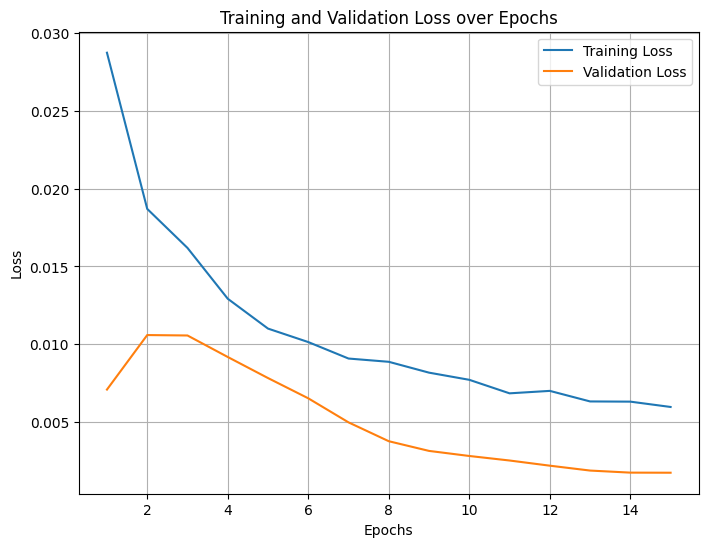

In [50]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss from the history object
def plot_loss(history):
    # Extract loss and val_loss from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']  # Make sure validation data is used in model.fit()

    # Create epochs range based on the number of epochs in history
    epochs_range = range(1, len(train_loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    
    # Set plot title and labels
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    # Display the plot
    plt.show()

# Assuming you have trained the model with validation data
plot_loss(history)

In [52]:
y_train_predict = model.predict(x_train)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


In [53]:
train_rmse = math.sqrt(mean_squared_error(y_train, y_train_predict))
train_rmse

0.06860483909009087